# Investigating GloVe embeddings

In [1]:
import operator 
from collections import defaultdict
from time import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from IPython.display import display
pd.set_option('display.max_colwidth', -1)
from tqdm import tqdm
tqdm.pandas()

import re
from gensim.models import KeyedVectors

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Activation, Dropout, Embedding, SpatialDropout1D 
from tensorflow.keras.layers import CuDNNLSTM, LSTM, Bidirectional, CuDNNGRU, GRU
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from keras_tqdm import TQDMNotebookCallback

C:\Users\tprjo\AppData\Local\conda\conda\envs\py36\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [52]:
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(51)]:
        score = metrics.f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

## Import data

In [35]:
train = pd.read_csv('../../data/train.csv')
#test = pd.read_csv('../../data/test.csv')
print(train.shape)
#print(test.shape)
train.fillna('_na_', inplace=True)

(1306122, 3)


In [7]:
# Load Embedding file using google news word2vec
EMBEDDING_FILE = '../../data/embeddings/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE,  encoding="utf8"))


In [10]:
EMBEDDING_DIM = len(embeddings_index['word'])

## Preprocessing

In [12]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [13]:
def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    covered_word_count = 0
    oov_word_count = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            covered_word_count += vocab[word]
        except:

            oov[word] = vocab[word]
            oov_word_count += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(covered_word_count / (covered_word_count + oov_word_count)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [14]:
sentences = list(map(lambda sent: sent.split(), train["question_text"]))
vocab = build_vocab(sentences) 

oov = check_coverage(vocab, embeddings_index)

100%|██████████████████████████████████████████████████████████████████████| 508823/508823 [00:00<00:00, 822827.70it/s]


Found embeddings for 33.16% of vocab
Found embeddings for  88.16% of all text


In [15]:
oov[:20]

[('India?', 16384),
 ('it?', 12900),
 ("What's", 12425),
 ('do?', 8753),
 ('life?', 7753),
 ('you?', 6295),
 ('me?', 6202),
 ('them?', 6140),
 ('time?', 5716),
 ('world?', 5386),
 ('people?', 4971),
 ('why?', 4943),
 ('Quora?', 4655),
 ('like?', 4487),
 ('for?', 4450),
 ('work?', 4206),
 ('2017?', 4050),
 ('mean?', 3971),
 ('2018?', 3594),
 ('country?', 3422)]

In [21]:
#for symbol in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~/-&“”’':
#    print(symbol, symbol in embeddings_index)

In [34]:
def space_punct(x):
    x = str(x)
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~/-&“”’':
        x = x.replace(punct, f' {punct} ')
    return x

In [36]:
train["question_text"] = train["question_text"].apply(lambda x: space_punct(x))
sentences = train["question_text"].apply(lambda x: x.split())
vocab = build_vocab(sentences)




  0%|                                                                                      | 0/1306122 [00:00<?, ?it/s]


  1%|▍                                                                       | 7160/1306122 [00:00<00:18, 71060.12it/s]


  1%|▉                                                                      | 16675/1306122 [00:00<00:16, 76768.83it/s]


  2%|█▍                                                                     | 25710/1306122 [00:00<00:15, 80233.09it/s]


  3%|█▉                                                                     | 35619/1306122 [00:00<00:14, 84931.09it/s]


  3%|██▍                                                                    | 45491/1306122 [00:00<00:14, 88453.90it/s]


  4%|███                                                                    | 55338/1306122 [00:00<00:13, 91053.30it/s]


  5%|███▌                                                                   | 65333/1306122 [00:00<00:13, 93361.40it/s]


  6%|████            

 48%|█████████████████████████████████▋                                    | 628261/1306122 [00:06<00:07, 88655.57it/s]


 49%|██████████████████████████████████▏                                   | 637141/1306122 [00:06<00:07, 88242.25it/s]


 49%|██████████████████████████████████▋                                   | 646371/1306122 [00:07<00:07, 89232.80it/s]


 50%|███████████████████████████████████▏                                  | 656036/1306122 [00:07<00:07, 91146.00it/s]


 51%|███████████████████████████████████▋                                  | 665168/1306122 [00:07<00:07, 90998.93it/s]


 52%|████████████████████████████████████▏                                 | 674501/1306122 [00:07<00:06, 91488.54it/s]


 52%|████████████████████████████████████▋                                 | 683797/1306122 [00:07<00:06, 91727.53it/s]


 53%|█████████████████████████████████████▏                                | 692977/1306122 [00:07<00:06, 91276.23it/s]


 54%|███████████████████

 95%|█████████████████████████████████████████████████████████████████▌   | 1241717/1306122 [00:13<00:00, 89800.74it/s]


 96%|██████████████████████████████████████████████████████████████████   | 1250703/1306122 [00:13<00:00, 89355.70it/s]


 96%|██████████████████████████████████████████████████████████████████▌  | 1259643/1306122 [00:13<00:00, 88362.12it/s]


 97%|███████████████████████████████████████████████████████████████████  | 1268485/1306122 [00:13<00:00, 87664.39it/s]


 98%|███████████████████████████████████████████████████████████████████▍ | 1277401/1306122 [00:14<00:00, 87914.43it/s]


 98%|███████████████████████████████████████████████████████████████████▉ | 1286197/1306122 [00:14<00:00, 87742.17it/s]


 99%|████████████████████████████████████████████████████████████████████▍| 1294974/1306122 [00:14<00:00, 87302.30it/s]


100%|████████████████████████████████████████████████████████████████████▊| 1303707/1306122 [00:14<00:00, 87112.16it/s]


100%|███████████████████

In [37]:
oov = check_coverage(vocab,embeddings_index)




  0%|                                                                                       | 0/242041 [00:00<?, ?it/s]


 33%|███████████████████████▎                                               | 79295/242041 [00:00<00:00, 786937.51it/s]


 70%|████████████████████████████████████████████████▋                     | 168412/242041 [00:00<00:00, 813748.00it/s]


100%|██████████████████████████████████████████████████████████████████████| 242041/242041 [00:00<00:00, 825178.12it/s]

Found embeddings for 74.04% of vocab
Found embeddings for  99.56% of all text


In [40]:
# Remove all words that are not in the embedding
remove_not_in_embed = lambda sent: ' '.join([word for word in sent.split() if word in embeddings_index])
train["question_text"] = train["question_text"].apply(remove_not_in_embed)
#test["question_text"] = test["question_text"].progress_apply(remove_not_in_embed)




  0%|                                                                                      | 0/1306122 [00:00<?, ?it/s]


  1%|▊                                                                     | 14748/1306122 [00:00<00:08, 146095.57it/s]


  3%|██▏                                                                   | 39714/1306122 [00:00<00:07, 164518.52it/s]


  5%|███▍                                                                  | 63226/1306122 [00:00<00:06, 178273.93it/s]


  7%|████▋                                                                 | 87257/1306122 [00:00<00:06, 192749.29it/s]


  9%|██████                                                               | 115674/1306122 [00:00<00:05, 206116.51it/s]


 11%|███████▍                                                             | 139701/1306122 [00:00<00:05, 215142.15it/s]


 13%|████████▋                                                            | 164612/1306122 [00:00<00:05, 215248.98it/s]


 15%|██████████▏     

In [41]:
sentences = train["question_text"].apply(lambda x: x.split())
vocab = build_vocab(sentences)




  0%|                                                                                      | 0/1306122 [00:00<?, ?it/s]


  2%|█▍                                                                    | 27844/1306122 [00:00<00:04, 276367.33it/s]


  5%|███▍                                                                  | 63242/1306122 [00:00<00:04, 295288.17it/s]


  8%|█████▎                                                                | 98819/1306122 [00:00<00:03, 310587.85it/s]


 10%|███████▏                                                             | 136015/1306122 [00:00<00:03, 326036.92it/s]


 13%|█████████▏                                                           | 172955/1306122 [00:00<00:03, 337261.78it/s]


 16%|███████████                                                          | 209815/1306122 [00:00<00:03, 345413.44it/s]


 19%|████████████▉                                                        | 244119/1306122 [00:00<00:03, 343907.12it/s]


 21%|██████████████▋ 

In [42]:
oov = check_coverage(vocab, embeddings_index)
vocab_size = len(vocab)
print(f'Vocabulary size is {vocab_size}')




  0%|                                                                                       | 0/179210 [00:00<?, ?it/s]


 49%|██████████████████████████████████▌                                    | 87382/179210 [00:00<00:00, 820327.35it/s]


 98%|████████████████████████████████████████████████████████████████████▎ | 174763/179210 [00:00<00:00, 828513.66it/s]


100%|██████████████████████████████████████████████████████████████████████| 179210/179210 [00:00<00:00, 827819.82it/s]

Found embeddings for 100.00% of vocab
Found embeddings for  100.00% of all text
Vocabulary size is 179210


In [43]:
# Learn a number for each word 
tk = Tokenizer(lower=False, filters='')
tk.fit_on_texts(sentences)

# Dictionary to convert word to its number
word_index = tk.word_index
print('Found %s unique tokens.' % len(word_index))

Found 179210 unique tokens.


In [44]:
# Convert each word to a number 
sequences = tk.texts_to_sequences(sentences)

In [45]:
MAX_SEQUENCE_LENGTH = 50
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [46]:
# Create embeddings matrix, will be vocab size + 1 x embedding size  (+1 something to do with mask)
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Create Model

In [47]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, train['target'].values, test_size=0.1, random_state=42, stratify=train['target'].values)

In [54]:
K.clear_session()

model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))
model.add(SpatialDropout1D(0.3))

model.add(CuDNNLSTM(128))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           53763300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 300)           0         
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 128)               220160    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
__________

In [55]:
%%time
num_epochs = 20
callback = EarlyStopping(patience=2, monitor='val_loss')
seqModel = model.fit(X_train, y=y_train, batch_size=512, epochs=num_epochs,
                     verbose=0, validation_data=(X_test, y_test), callbacks=[callback, TQDMNotebookCallback(leave_inner=True, leave_outer=True)])


Wall time: 17min 53s


In [56]:
keras_predict = model.predict_classes(X_test)
metrics.f1_score(y_test, keras_predict)

0.6873154488911226

In [57]:
keras_train_probas = model.predict(X_train)
keras_search = threshold_search(y_train, keras_train_probas)
print(keras_search)

keras_test_probas = model.predict(X_test)
threshold_predictions = keras_test_probas > keras_search['threshold']

metrics.f1_score(y_test, threshold_predictions)

{'threshold': 0.38, 'f1': 0.7510735364491945}


0.6935315294390896

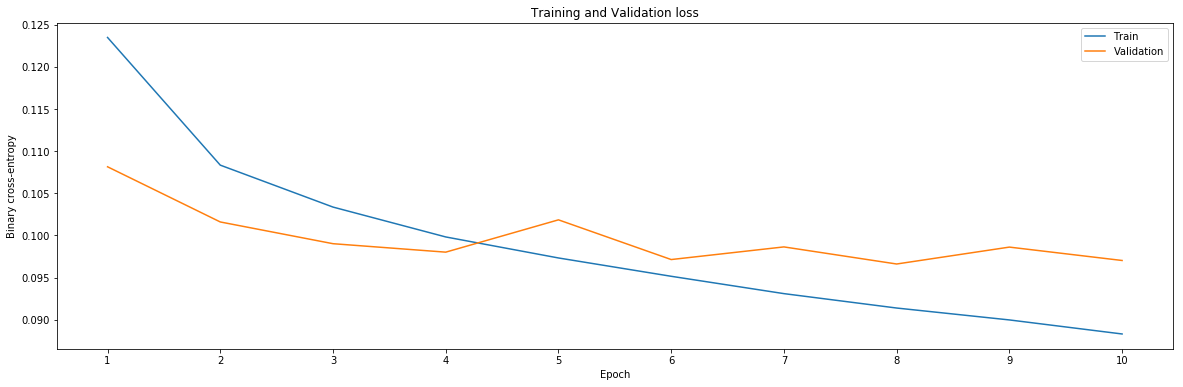

In [58]:
# visualizing losses and accuracy
train_loss = seqModel.history['loss']
val_loss   = seqModel.history['val_loss']
num_trained_epochs = len(train_loss)
xc         = np.array(list(range(num_trained_epochs))) + 1

plt.figure(figsize=(20, 6))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('Epoch')
_ = plt.xticks([x+1 for x in range(num_trained_epochs)])
plt.ylabel('Binary cross-entropy')
plt.legend(['Train', 'Validation'])
_ = plt.title('Training and Validation loss')